# [T256075](https://phabricator.wikimedia.org/T256075) Post Deployment Data QA - Collapsible Sidebar Instrumentation

In this task we will be verifying if events fired in the test wikis are making it to the schema [DesktopWebUIActionsTracking](https://meta.wikimedia.org/wiki/Schema:DesktopWebUIActionsTracking) and if the Instrumentation is working correctly.  
**Part 1:**
- euwiki  
- frwiktionary
- ptwikiversity

**Part 2:**
- frwiki
- hewiki
- fawiki

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str

You are using wmfdata v1.0.1, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


### Count events in DesktopWebUIActionsTracking

In [13]:
# Count all events  

count_actions = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 19   
  AND wiki <> 'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action
""")

In [17]:
count_actions_pivot=count_actions.pivot(index="date",columns='action', values='events').fillna(0)

In [18]:
count_actions_pivot

action,click,init
date,,
2020-07-20,0.0,1.0
2020-07-22,618.0,22058.0
2020-07-23,829.0,33483.0
2020-07-24,513.0,26760.0


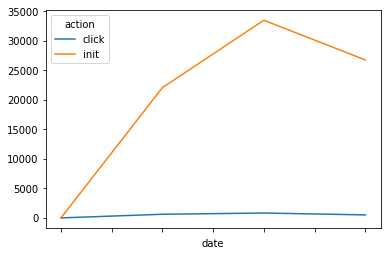

In [19]:
count_actions_pivot.plot()

### Count events by Wiki

In [8]:
# Check by Wiki 

count_actions_wiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 19 
  AND wiki <>'testwiki'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action, wiki
""")

In [9]:
count_actions_wiki_pivot=count_actions_wiki.pivot_table(index=["wiki","date"],
                                                        columns=["action"], values=['events']).fillna(0)
count_actions_wiki_pivot

events         
action                    click     init
wiki          date                      
enwiki        2020-07-20    0.0      1.0
euwiki        2020-07-22  241.0   1368.0
              2020-07-23  262.0   2100.0
              2020-07-24  197.0   1414.0
frwiktionary  2020-07-22  371.0  20458.0
              2020-07-23  545.0  31061.0
              2020-07-24  306.0  25118.0
ptwikiversity 2020-07-22    6.0    232.0
              2020-07-23   22.0    322.0
              2020-07-24   10.0    228.0

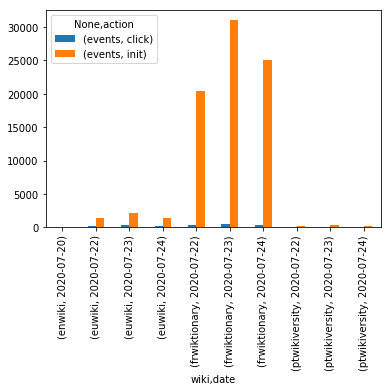

In [10]:
count_actions_wiki_pivot.plot.bar()

### Count events by skinVersion

In [11]:
# Check by skinVersion 

count_actions_skinVersion = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 19   
  AND wiki <> 'testwiki'
GROUP BY event.action, event.skinversion
""")

In [12]:
count_actions_skinVersion.pivot(index='skinversion', columns='action')

events       
action       click   init
skinversion              
1              332   2095
2             1628  80207

### Count of events by skinVersion on test wikis

In [6]:
# Check by skinVersion and wiki

count_actions_skinVersion_wiki = hive.run("""
SELECT
  event.action AS action,
  event.skinversion as skinversion,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day > 19   
GROUP BY event.action, event.skinversion, wiki
""")

In [7]:
count_actions_skinVersion_wiki.pivot_table(index=['wiki','skinversion'],columns=['action']).fillna(0)

events         
action                      click     init
wiki          skinversion                 
enwiki        1               0.0      1.0
euwiki        1             190.0    487.0
              2             498.0   4264.0
frwiktionary  1             136.0   1576.0
              2            1048.0  72772.0
ptwikiversity 1               3.0     15.0
              2              33.0    726.0
testwiki      1            1543.0   3985.0
              2             918.0    799.0

### Clicks to the Collapsible Sidebar

In [8]:
# Collapsible sidebar events by Date

count_actions_sidebar = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>19
  AND event.name LIKE 'ui.%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

In [41]:
count_actions_sidebar_pivot=count_actions_sidebar.pivot(index='date', columns='name')
count_actions_sidebar_pivot

,events
name,ui.sidebar
date,
2020-07-16,9
2020-07-17,23
2020-07-18,8
2020-07-19,6
2020-07-20,28
2020-07-22,310
2020-07-23,511
2020-07-24,186


Please note : this includes [Testwiki](https://test.wikipedia.org/wiki/Main_Page)

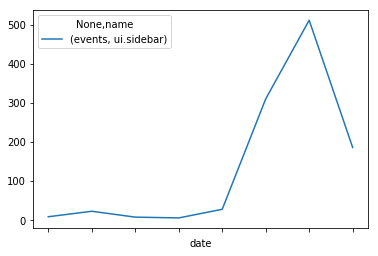

In [43]:
count_actions_sidebar_pivot.plot()

In [10]:
# Collapsible sidebar events by Wiki and date

count_actions_sidebarwiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>18
  AND event.name LIKE 'ui.%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

In [11]:
count_actions_sidebarwiki.pivot_table(index=['wiki','date'], columns=['name'])

events
name                     ui.sidebar
wiki          date                 
euwiki        2020-07-22         86
              2020-07-23        124
              2020-07-24         54
frwiktionary  2020-07-22        219
              2020-07-23        295
              2020-07-24        129
ptwikiversity 2020-07-23          6
testwiki      2020-07-19          6
              2020-07-20         28
              2020-07-22          5
              2020-07-23         86
              2020-07-24          3

## Donate link events
With the implementation of the Collapsible Sidebar, we are interested to understand in particular, what is the overall difference in interaction with the donate link?

**Donate link name = "n-sitesupport"**


In [12]:
# Donate link events

count_donate_events = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>19
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name
""")

In [13]:
count_donate_events

,date,name,events
0,2020-07-16,n-sitesupport,2
1,2020-07-18,n-sitesupport,1
2,2020-07-20,n-sitesupport,22
3,2020-07-21,n-sitesupport,80
4,2020-07-23,n-sitesupport,264


In [14]:
# Donate link events by Wiki

count_donate_wiki = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 and day>19
  AND event.name LIKE 'n-site%'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.name, wiki
""")

No Clicks recorded on the Donate link on any of the 6 test wikis so far

In [15]:
count_donate_wiki.pivot_table(index=['wiki','name'], columns=['date'])

events                                              \
date                   2020-07-15 2020-07-16 2020-07-18 2020-07-20 2020-07-21   
wiki     name                                                                   
testwiki n-sitesupport          9          2          1         22         80   

                                   
date                   2020-07-23  
wiki     name                      
testwiki n-sitesupport        264

In [16]:
# Donate link events on Wikis by skinVersion

count_donate_skinVersion= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki
""")

In [17]:
count_donate_skinVersion.pivot_table(index=['name','wiki','skinversion'])

events
name          wiki     skinversion        
n-sitesupport testwiki 1               134
                       2               235

In [18]:
# Donate link events by logged in/out users

count_donate_skinVersion_anon= hive.run("""
SELECT
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-sitesupport'
GROUP BY event.skinversion, event.name, wiki, event.isanon 
""")

In [19]:
count_donate_skinVersion_anon.pivot_table(index=['name','wiki','skinversion'], columns=['anonymous_user']).fillna(0)

events      
anonymous_user                      False True 
name          wiki     skinversion             
n-sitesupport testwiki 1               59    75
                       2              165    70

In [20]:
# Donate link events by logged in/out users by day

count_donate_skinVersion_anon_day= hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-sitesupport'
GROUP BY date_format(dt, "yyyy-MM-dd"),event.skinversion, event.name, wiki, event.isanon 
""")

In [21]:
count_donate_skinVersion_anon_day.pivot_table(index=
                                              ['name','wiki','date','skinversion'], 
                                              columns=['anonymous_user']).fillna(0)

events      
anonymous_user                                 False True 
name          wiki     date       skinversion             
n-sitesupport testwiki 2020-07-16 1              0.0   2.0
                       2020-07-18 2              1.0   0.0
                       2020-07-20 1              0.0  10.0
                                  2              2.0  10.0
                       2020-07-21 2             80.0   0.0
                       2020-07-23 1             59.0  63.0
                                  2             82.0  60.0

In [22]:
# Other Sidebar links

count_sidebar_skinVersion_anon_day= hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.skinversion,
  event.name as name,
  wiki AS wiki,
  event.isanon AS anonymous_user,
  COUNT(*) AS events
FROM event.desktopwebuiactionstracking
WHERE
  year = 2020 
  AND month=7 AND day>19
  AND event.name LIKE 'n-%' 
  AND wiki <> 'testwiki' 
  
GROUP BY date_format(dt, "yyyy-MM-dd"),event.skinversion, event.name, wiki, event.isanon 
""")

In [23]:
count_sidebar_skinVersion_anon_day.pivot_table(index=
                                              ['name','wiki','date','skinversion'], 
                                              columns=['anonymous_user']).fillna(0)

events  \
anonymous_user                                                                 False   
name                                     wiki          date       skinversion          
n-Création-rapide                        frwiktionary  2020-07-23 2              1.0   
n-Cursos                                 ptwikiversity 2020-07-23 2              0.0   
n-Discuter-sur-Discord                   frwiktionary  2020-07-22 2              1.0   
n-Esplanada                              ptwikiversity 2020-07-22 1              0.0   
n-La-Wikidémie                           frwiktionary  2020-07-22 2              1.0   
                                                       2020-07-23 1              1.0   
                                                                  2              0.0   
                                                       2020-07-24 2              0.0   
n-Modèles                                frwiktionary  2020-07-22 2              0.0   
n-Recherche-avancée,-anagrammes-et-rimes frwiktionary  2020-07-23 2              0.0   
n-Txikipedia                             euwiki        2020-07-23 2              4.0   
n-help                                   euwiki        2020-07-22 2              1.0   
n-mainpage                               euwiki        2020-07-22 2              3.0   
                                                       2020-07-23 2              2.0   
                                                       2020-07-24 2              1.0   
n-mainpage-description                   ptwikiversity 2020-07-22 1              0.0   
                                                       2020-07-23 2              1.0   
n-mainpage-name                          frwiktionary  2020-07-22 1              1.0   
                                                                  2              0.0   
                                                       2020-07-23 2              3.0   
                                                       2020-07-24 2              0.0   
n-portal                                 frwiktionary  2020-07-22 1              1.0   
                                                                  2              1.0   
                                                       2020-07-23 1              2.0   
                                                                  2              2.0   
                                                       2020-07-24 1              1.0   
                                         ptwikiversity 2020-07-23 2              0.0   
n-randompage                             euwiki        2020-07-22 1              0.0   
                                                                  2              2.0   
                                                       2020-07-23 2              1.0   
                                         frwiktionary  2020-07-22 1              0.0   
                                                                  2              1.0   
                                                       2020-07-23 1              2.0   
                                                                  2              0.0   
                                                       2020-07-24 2              0.0   
n-randompagebylang                       frwiktionary  2020-07-24 2              0.0   
n-recentchanges                          euwiki        2020-07-22 2              5.0   
                                                       2020-07-23 2              3.0   
                                                       2020-07-24 2              1.0   
                                         frwiktionary  2020-07-22 1              2.0   
                                                                  2              3.0   
                                                       2020-07-23 1              4.0   
                                                                  2              3.0   
                              